In [19]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import utils as lbl_utils
import ct_two_state as ct2
import ct_three_state as ct3
import fixed_time_horizon as fth
import oracle
import triple_barrier as tb

[*********************100%%**********************]  1 of 1 completed
(6835,)
Datetime
2024-01-02 12:07:00    2075.5
2024-01-02 12:08:00    2075.0
2024-01-02 12:09:00    2074.5
2024-01-02 12:10:00    2075.0
2024-01-02 12:11:00    2075.0
Name: Close, dtype: float64
Datetime
2024-01-09 11:59:00    2037.199951
2024-01-09 12:00:00    2036.900024
2024-01-09 12:01:00    2037.199951
2024-01-09 12:02:00    2037.800049
2024-01-09 12:03:00    2037.800049
Name: Close, dtype: float64
Datetime
2024-01-07 22:02:00    2047.199951
2024-01-07 22:03:00    2047.199951
Name: Close, dtype: float64
2024-01-02     651
2024-01-03    1372
2024-01-04    1359
2024-01-05    1011
2024-01-07     359
2024-01-08    1378
2024-01-09     705
Name: Close, dtype: int64


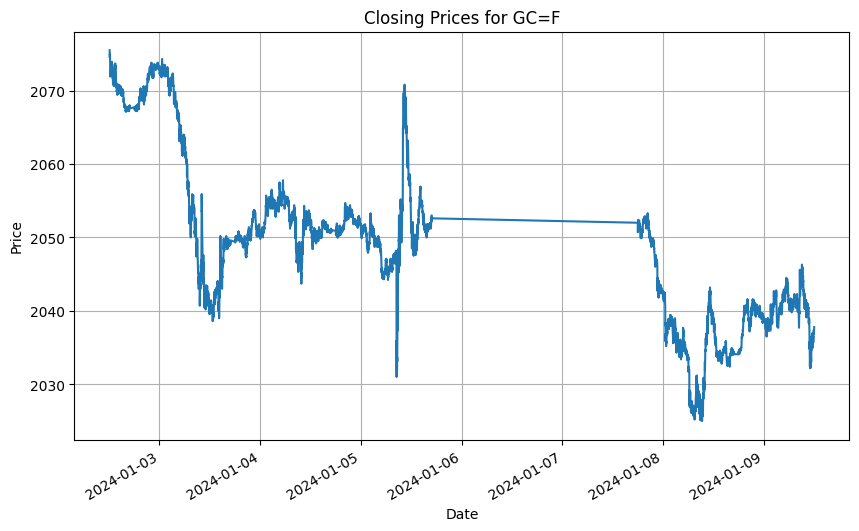

In [20]:
ticker_symbol = 'GC=F'
start_date = '2000-01-01'
end_date = '2023-11-01'

prices = yf.download(ticker_symbol, interval='1m')['Close']
prices.index = prices.index.tz_localize(None)

print(prices.shape)
print(prices.head())
print(prices.tail())
print(prices.iloc[-2200:-2198])

# Group by date and count the samples per day
samples_per_day = prices.groupby(prices.index.date).size()
print(samples_per_day)

# Plotting the prices
plt.figure(figsize=(10, 6))
prices.plot(title=f'Closing Prices for {ticker_symbol}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [13]:
ticker_symbol = 'GC=F'
start_date = '2000-01-01'
end_date = '2023-11-01'

prices = yf.download(ticker_symbol, start_date, end_date, interval='1d')['Close']
prices.index = prices.index.tz_localize(None)

print(prices.shape)
print(prices.head())

[*********************100%%**********************]  1 of 1 completed
(5813,)
Date
2000-08-30    273.899994
2000-08-31    278.299988
2000-09-01    277.000000
2000-09-05    275.799988
2000-09-06    274.200012
Name: Close, dtype: float64


In [2]:
ticker_symbol = 'GC=F'
start_date = '2000-01-01'
end_date = '2023-11-01'

prices = yf.download(ticker_symbol, start_date, end_date, interval='1d')['Close']
prices.index = prices.index.tz_localize(None)

print(prices.shape)
print(prices.head())

[*********************100%%**********************]  1 of 1 completed
(5813,)
Date
2000-08-30    273.899994
2000-08-31    278.299988
2000-09-01    277.000000
2000-09-05    275.799988
2000-09-06    274.200012
Name: Close, dtype: float64


In [3]:
# trans_fee = 0.0004
# #-------------------------------------------
# tau = 0.0004
# labels = ct2.binary_trend_labels(prices, tau=tau)
# lbl_utils.plot_labels('CT2; {}; tau={}'.format(ticker_symbol, tau), prices, labels)
# print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
# #-------------------------------------------
# tau = 0.0004
# window = 3
# labels = ct3.get_labels(prices, tau=tau, w=window)
# lbl_utils.plot_labels('CT3; {}; tau={} w={}'.format(ticker_symbol, tau, window), prices, labels)
# print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
# #-------------------------------------------
# tau = 0.0002
# H = 1
# labels = fth.binary_trend_labels(prices, tau=tau, H=H)
# lbl_utils.plot_labels('FTH; {}; tau={} H={}'.format(ticker_symbol, tau, H), prices, labels)
# print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
# #-------------------------------------------
# fee = 0.0004
# labels = oracle.binary_trend_labels(prices, fee=fee)
# lbl_utils.plot_labels('Oracle; {}; fee={}'.format(ticker_symbol, fee), prices, labels)
# print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
# #-------------------------------------------
# tEvents = prices.index
# t1 = prices.index.searchsorted(tEvents + pd.Timedelta(hours=1))
# t1 = pd.Series((prices.index[i] if i < prices.shape[0] else pd.NaT for i in t1), index=tEvents)
# minuteVol = tb.getMinuteVol(prices, span=100)
# minuteVol = minuteVol.reindex(tEvents).loc[tEvents].fillna(method='bfill')
# labels = tb.get_labels(prices, tEvents, ptSl=[1, 2], volatility=minuteVol, minRet=0, t1=t1)
# lbl_utils.plot_labels('Triple Barrier; {}'.format(ticker_symbol), prices, labels)
# print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
# #-------------------------------------------
# # Meta labeling
# #side = labels
# #side[side == 0] = -1
# #side = side.shift(1).fillna(method='bfill')
# #labels_2 = tb.get_labels(prices, tEvents, ptSl=[1, 2], volatility=minuteVol, minRet=0, t1=t1, side=side)
# # iterate through labels_2 and if it has value 1 set ti to value from labels on same index, otherwise set to 0
# #labels_2 = pd.Series((labels[i] if labels_2[i] == 1 else 0 for i in labels_2.index), index=labels_2.index)
# #lbl_utils.plot_labels('TB Meta Labeling; {}'.format(ticker_symbol), prices, labels_2)


In [4]:
fee = 0.0004
num_threads = 16
file_store = '../artifacts/labels/params_detail_tb.txt'
# #-------------------------------------------
# # CT2
# print('Optimizing CT2')
# param_grid = [
#     np.arange(0, 0.003, 0.00002).tolist() # tau
# ]
# best_params = lbl_utils.optimize_label_params(binary_trend_labels=ct2.binary_trend_labels, prices=prices
#                                         , param_grid=param_grid, fee=fee, num_threads=num_threads)
# with open(file_store, 'a') as f:
#     f.write('CT2; fee={}; tau={}\n'.format(fee, best_params[0]))
# # CT3
# print('Optimizing CT3')
# param_grid = [
#     np.arange(0, 0.003, 0.00002).tolist(),  # tau
#     np.arange(0, 20, 1).tolist()            # window
# ]
# best_params = lbl_utils.optimize_label_params(binary_trend_labels=ct3.binary_trend_labels, prices=prices, 
#                                               param_grid=param_grid, fee=fee, num_threads=num_threads)
# with open(file_store, 'a') as f:
#     f.write('CT3; fee={}; tau={}; window={}\n'.format(fee, best_params[0], best_params[1]))

# # FTH
# print('Optimizing FTH')
# param_grid = [
#     np.arange(0, 0.0003, 0.000001).tolist(),  # tau
#     np.arange(1, 20, 1).tolist()            # H
# ]
# best_params = lbl_utils.optimize_label_params(binary_trend_labels=fth.binary_trend_labels, prices=prices,
#                                               param_grid=param_grid, fee=fee, num_threads=num_threads)
# with open(file_store, 'a') as f:
#     f.write('FTH; fee={}; tau={}; H={}\n'.format(fee, best_params[0], best_params[1]))

# # Triple Barrier
# print('Optimizing Triple Barrier')
# tEvents = prices.index
# t1_list = []
# for window in range(10, 150, 10):
#     t1 = prices.index.searchsorted(tEvents + pd.Timedelta(days=window))
#     t1 = pd.Series((prices.index[i] if i < prices.shape[0] else pd.NaT for i in t1), index=tEvents)
#     t1_list.append(t1)
# dayVolList = []
# for span in range(40, 200, 20):
#     dayVol = tb.getDayVol(prices, span=100)
#     dayVol = dayVol.reindex(tEvents).loc[tEvents].fillna(method='bfill')
#     dayVolList.append(dayVol)
# param_grid = [
#     [tEvents],                          # tEvents
#     np.arange(0, 2, 0.1).tolist(),  #pt
#     np.arange(0, 2, 0.1).tolist(),  #sl
#     dayVolList,                        # volatility
#     [0],                                # minRet
#     t1_list,                               # t1
# ]
# best_params = lbl_utils.optimize_label_params(binary_trend_labels=tb.binary_trend_labels, prices=prices,
#                                               param_grid=param_grid, fee=fee, num_threads=num_threads)

# best_dayVol = best_params[3]
# best_t1 = best_params[5]

# # Find the index in the respective lists
# best_dayVol_index = dayVolList.index(best_dayVol)
# best_t1_index = t1_list.index(best_t1)

# # Calculate the span and window values from the indexes
# best_span = 40 + (best_dayVol_index * 20)
# best_window = 10 + (best_t1_index * 10)

# print('TB; fee={}; pt={}; sl={}; vol_span={}; f1_window={}'.format(fee, best_params[1], best_params[2], best_span, best_window))
# with open(file_store, 'a') as f:
#     f.write('TB; fee={}; pt={}; sl={}; vol_span={}; f1_window={}\n'.format(fee, best_params[1], best_params[2], best_span, best_window))

In [5]:
# def calculate_annual_return(cumulative_return, prices):
#     # Calculate the number of years
#     start_date = prices.index[0]
#     end_date = prices.index[-1]
#     n_years = (end_date - start_date).days / 365.25  # using 365.25 to account for leap years

#     # Calculate the average annual return
#     average_annual_return = (1 + cumulative_return / 100) ** (1 / n_years) - 1
#     return average_annual_return * 100  # Convert to percentage

In [6]:
# trans_fee = 0.0004
# plot_last_n = 50
# #-------------------------------------------
# tau = 0.00298
# labels = ct2.binary_trend_labels(prices, tau=tau)
# lbl_utils.plot_labels('CT2; {}; tau={}'.format(ticker_symbol, tau), prices.tail(plot_last_n), labels.tail(plot_last_n))
# cumulative_return = lbl_utils.compute_return(prices, labels, trans_fee)*100
# print('average_annual_return: {}%'.format(calculate_annual_return(cumulative_return, prices)))
# #-------------------------------------------
# tau = 0.00176
# window = 16
# labels = ct3.binary_trend_labels(prices, tau=tau, w=window)
# lbl_utils.plot_labels('CT3; {}; tau={} w={}'.format(ticker_symbol, tau, window), prices.tail(plot_last_n), labels.tail(plot_last_n))
# cumulative_return = lbl_utils.compute_return(prices, labels, trans_fee)*100
# print('average_annual_return: {}%'.format(calculate_annual_return(cumulative_return, prices)))
# #-------------------------------------------
# tau = 0
# H = 1
# labels = fth.binary_trend_labels(prices, tau=tau, H=H)
# lbl_utils.plot_labels('FTH; {}; tau={} H={}'.format(ticker_symbol, tau, H), prices.tail(plot_last_n), labels.tail(plot_last_n))
# cumulative_return = lbl_utils.compute_return(prices, labels, trans_fee)*100
# print('average_annual_return: {}%'.format(calculate_annual_return(cumulative_return, prices)))
# #-------------------------------------------
# fee = 0.0004
# labels = oracle.binary_trend_labels(prices, fee=fee)
# lbl_utils.plot_labels('Oracle; {}; fee={}'.format(ticker_symbol, fee), prices.tail(plot_last_n), labels.tail(plot_last_n))
# cumulative_return = lbl_utils.compute_return(prices, labels, trans_fee)*100
# print('average_annual_return: {}%'.format(calculate_annual_return(cumulative_return, prices)))
# #-------------------------------------------
# tEvents = prices.index
# t1 = prices.index.searchsorted(tEvents + pd.Timedelta(days=30))
# t1 = pd.Series((prices.index[i] if i < prices.shape[0] else pd.NaT for i in t1), index=tEvents)
# minuteVol = tb.getMinuteVol(prices, span=100)
# minuteVol = minuteVol.reindex(tEvents).loc[tEvents].fillna(method='bfill')
# labels = tb.binary_trend_labels(prices, tEvents, pt=0.1, sl=0.7, volatility=minuteVol, minRet=0, t1=t1)
# lbl_utils.plot_labels('Triple Barrier; {}'.format(ticker_symbol), prices.tail(plot_last_n), labels.tail(plot_last_n))
# cumulative_return = lbl_utils.compute_return(prices, labels, trans_fee)*100
# print('average_annual_return: {}%'.format(calculate_annual_return(cumulative_return, prices)))

In [7]:
# import pickle

# with open('labels_dict.pkl', 'rb') as file:
#         labels_dict = pickle.load(file)
# old_tp_labels = labels_dict['triple_barrier']

# ticker_symbol = 'GC=F'
# start_date = '2000-01-01'
# end_date = '2023-11-01'

# prices = yf.download(ticker_symbol, start_date, end_date, interval='1d')['Close']
# prices.index = prices.index.tz_localize(None)

In [8]:
# # optimize
# trans_fee = 0.0004
# num_threads = 16
# #-------------------------------------------
# tEvents = prices.index
# t1 = prices.index.searchsorted(tEvents + pd.Timedelta(hours=1))
# t1 = pd.Series((prices.index[i] if i < prices.shape[0] else pd.NaT for i in t1), index=tEvents)
# minuteVol = tb.getMinuteVol(prices, span=100)
# minuteVol = minuteVol.reindex(tEvents).loc[tEvents].fillna(method='bfill')
# param_grid = [
#     [tEvents],                          # tEvents
#     np.arange(0, 4.2, 0.1).tolist(),  #pt
#     np.arange(0, 4.2, 0.1).tolist(),  #sl
#     [minuteVol],                        # volatility
#     [0],                                # minRet
#     [t1],                               # t1
# ]
# best_params = lbl_utils.optimize_label_params(binary_trend_labels=tb.binary_trend_labels, prices=prices,
#                                               param_grid=param_grid, fee=trans_fee, num_threads=num_threads)

In [9]:
# # lbl_utils.plot_labels('Triple Barrier; {}'.format(ticker_symbol), prices, old_tp_labels)
# # #-------------------------------------------
# tEvents = prices.index
# t1 = prices.index.searchsorted(tEvents + pd.Timedelta(days=30))
# t1 = pd.Series((prices.index[i] if i < prices.shape[0] else pd.NaT for i in t1), index=tEvents)
# minuteVol = tb.getMinuteVol(prices, span=100)
# minuteVol = minuteVol.reindex(tEvents).loc[tEvents].fillna(method='bfill')
# labels = tb.binary_trend_labels(prices, tEvents, pt=1, sl=0.7, volatility=minuteVol, minRet=0, t1=t1)
# lbl_utils.plot_labels('Triple Barrier; {}'.format(ticker_symbol), prices, labels)
# print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))

In [10]:
# print(best_params[1], best_params[2])

In [11]:
# print(labels.value_counts())